### **Team Members:**

- **2501995093 - Caroline Angelina Sunarya**
- **2501996505 - Grace Shirley Cam**
- **2502008006 - Jocelyn Verna Siswanto**

### **Dataset Link:** [Click Here to View the Original Dataset](https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic)

## **Load Libraries & Dataset**

### **1. Load Libraries**

In [ ]:
!pip install spektral
!pip install --upgrade spektral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 3.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import PIL
import random
import shutil
import pathlib
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import scipy.sparse as sp
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.layers import Reshape
from scipy.spatial import Delaunay
from tensorflow.keras import layers
from spektral.layers import GCNConv
from keras.utils import to_categorical
from skimage import segmentation, measure
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### **2. Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Originally there are 9 folders in Skin Cancer ISIC dataset. However, due to insufficient resources, only the first 5 folders were used to train the model in this research. Therefore, there are 1380 images in the train directory and 80 images in the test directory. The classes for the multi-label image classification are `artinic keratosis`, `dermatofibroma`, `nevus`, `basal cell carcinoma`, and `melanoma`.

## **Convolutional Neural Network**

### **1. Data Preprocessing (for CNN)**

#### **1.1. Divide Image into Train & Validation Set**

In [ ]:
# Define parameters for the loader
batch_size = 64
img_height = 180
img_width = 180

In [ ]:
train_dir = pathlib.Path("/content/drive/MyDrive/skin-cancer-isic/Train")
test_dir = pathlib.Path("/content/drive/MyDrive/skin-cancer-isic/Test")

NameError: ignored

In [ ]:
image_count_train = len(list(train_dir.glob('*/*.jpg')))
print("Number of Images in Train Directory : ", image_count_train)
image_count_test = len(list(test_dir.glob('*/*.jpg')))
print("Number of Images in Test Directory  : ", image_count_test)
classes = os.listdir(train_dir)
print(classes)

NameError: ignored

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed = 1,
    validation_split = 0.20,
    subset = 'training',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed = 1,
    validation_split = 0.20,
    subset = 'validation',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed = 1,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 1380 files belonging to 5 classes.
Using 1104 files for training.
Found 1380 files belonging to 5 classes.
Using 276 files for validation.
Found 80 files belonging to 5 classes.


Around 80% or 1104 files of the original data will be used for training, and 20% or 276 files of the original data will be used for validation.

In [ ]:
# List out all classes of skin cancer based on the directory names and store in a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus']


In [ ]:
class_counts = {}
num = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total_samples = sum(class_counts.values())

for label, count in class_counts.items():
    proportion = count / total_samples
    num.append(0)
    print(f"Class {label}: {proportion:.2%} ({count} samples)")

Class 4: 25.09% (277 samples)
Class 3: 31.79% (351 samples)
Class 1: 27.17% (300 samples)
Class 2: 7.07% (78 samples)
Class 0: 8.88% (98 samples)


The percentage shows proportion of each classes in our dataset. This result above gave us insight that the classes are imbalanced. Because 3 classes have proportions around 30%, whereas 2 classes have proportions less than 10%.

#### **1.2. Data Visualization**

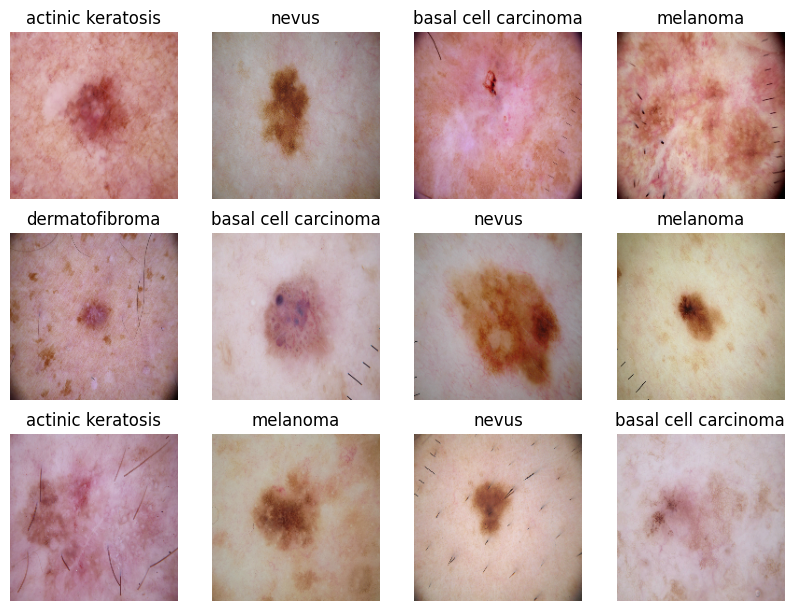

In [ ]:
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Displayed some images to give overall depiction of skin cancer images in our dataset.

#### **1.3. Data Augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

In [ ]:
# Get the number of samples in each class
class_counts = {}
for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

# Get the maximum number of samples in any class
max_class_count = max(class_counts.values())

train_ds_augmented = train_ds

In [ ]:
for i in range(3):
  # Create an empty list to hold the augmented samples
  augmented_images = []
  augmented_labels = []
  counter = [max_class_count, max_class_count, max_class_count, max_class_count, max_class_count]

  class_counts = {}
  for images, labels in train_ds_augmented:
      for label in labels.numpy():
          class_counts[label] = class_counts.get(label, 0) + 1
  for label, count in class_counts.items():
      num[label] = count

  # Loop over each batch of images and labels
  for images, labels in train_ds_augmented:
      # Loop over each image and label in the batch
      for image, label in zip(images, labels):
          # Add the original image and label to the augmented data
          augmented_images.append(image)
          augmented_labels.append(label)

          for i in range(len(num)):
              if class_counts[label.numpy()] == num[i]:
                  # Check if the current class has fewer samples than the maximum
                  if class_counts[label.numpy()] < counter[i]:
                    # Apply data augmentation to the image and add it to the augmented data
                    augmented_image = data_augmentation(image)
                    augmented_images.append(augmented_image)
                    augmented_labels.append(label)
                    counter[i] -= 1

  # Create a new balanced dataset from the augmented data
  train_ds_augmented = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels)).shuffle(len(augmented_images)).batch(batch_size)

In [ ]:
class_counts = {}

for images, labels in train_ds_augmented:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total_samples = sum(class_counts.values())

for label, count in class_counts.items():
    proportion = count / total_samples
    print(f"Class {label}: {proportion:.2%} ({count} samples)")

Class 2: 20.00% (351 samples)
Class 0: 20.00% (351 samples)
Class 4: 20.00% (351 samples)
Class 3: 20.00% (351 samples)
Class 1: 20.00% (351 samples)


In [ ]:
# Get the number of samples in each class
class_counts = {}
for images, labels in val_ds:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

# Get the maximum number of samples in any class
max_class_count = max(class_counts.values())

val_ds_augmented = val_ds

In [ ]:
for i in range(3):
  # Create an empty list to hold the augmented samples
  augmented_images = []
  augmented_labels = []
  counter = [max_class_count, max_class_count, max_class_count, max_class_count, max_class_count]

  class_counts = {}
  for images, labels in val_ds_augmented:
      for label in labels.numpy():
          class_counts[label] = class_counts.get(label, 0) + 1
  for label, count in class_counts.items():
      num[label] = count

  # Loop over each batch of images and labels
  for images, labels in val_ds_augmented:
      # Loop over each image and label in the batch
      for image, label in zip(images, labels):
          # Add the original image and label to the augmented data
          augmented_images.append(image)
          augmented_labels.append(label)

          for i in range(len(num)):
              if class_counts[label.numpy()] == num[i]:
                  # Check if the current class has fewer samples than the maximum
                  if class_counts[label.numpy()] < counter[i]:
                    # Apply data augmentation to the image and add it to the augmented data
                    augmented_image = data_augmentation(image)
                    augmented_images.append(augmented_image)
                    augmented_labels.append(label)
                    counter[i] -= 1

  # Create a new balanced dataset from the augmented data
  val_ds_augmented = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels)).shuffle(len(augmented_images)).batch(batch_size)

In [ ]:
class_counts = {}

for images, labels in val_ds_augmented:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total_samples = sum(class_counts.values())

for label, count in class_counts.items():
    proportion = count / total_samples
    print(f"Class {label}: {proportion:.2%} ({count} samples)")

Class 4: 20.00% (87 samples)
Class 0: 20.00% (87 samples)
Class 2: 20.00% (87 samples)
Class 1: 20.00% (87 samples)
Class 3: 20.00% (87 samples)


### **2. Convolutional Neural Network**

#### **2.1. Modeling**

1. First we create and define the CNN layers for our model:
 - 1 layer to rescale the images
 - 3 convolutional layers with 16, 32, and 64 filters
 - 3 pooling layers to reduce overfitting
 - 1 flatten layer
 - 2 dense layers (including an output layer) with 128 and 5 filters
2. Then we compile the model using model.compile to define the loss function, optimizers, and metrics for prediction.
3. After that, we train the model using model.fit.
4. Lastly, we check our model's overall accuracy and loss by plotting the accuracy and loss function.

##### **2.1.1. Define Layers**

In [ ]:
classes = 5

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)), #rescale dari range 0-255 menjadi 0-1
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(classes, activation='softmax')
])

##### **2.1.2. Model Fitting**

In [ ]:
# Model summary for all layers
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 50, batch_size=64)

Epoch 1/50
18/18 [==============================] - 22s 1s/step - loss: 1.6929 - accuracy: 0.3116 - val_loss: 1.3942 - val_accuracy: 0.3478
Epoch 2/50
18/18 [==============================] - 20s 991ms/step - loss: 1.3620 - accuracy: 0.4176 - val_loss: 1.2968 - val_accuracy: 0.5652
Epoch 3/50
18/18 [==============================] - 20s 967ms/step - loss: 1.2538 - accuracy: 0.4918 - val_loss: 1.0988 - val_accuracy: 0.6304
Epoch 4/50
18/18 [==============================] - 20s 961ms/step - loss: 1.0789 - accuracy: 0.5716 - val_loss: 1.0169 - val_accuracy: 0.5725
Epoch 5/50
18/18 [==============================] - 20s 985ms/step - loss: 0.9993 - accuracy: 0.6069 - val_loss: 0.9541 - val_accuracy: 0.6449
Epoch 6/50
18/18 [==============================] - 19s 939ms/step - loss: 0.9670 - accuracy: 0.6141 - val_loss: 0.9111 - val_accuracy: 0.6304
Epoch 7/50
18/18 [==============================] - 20s 978ms/step - loss: 0.9417 - accuracy: 0.6150 - val_loss: 0.9084 - val_accuracy: 0.6268
Ep

##### **2.1.3. Evaluating Model's Accuracy & Loss**

In [ ]:
val_loss, val_accuracy = model.evaluate(val_ds)
train_loss, train_accuracy = model.evaluate(train_ds)

print("Training loss:", train_loss)
print("Training accuracy:", train_accuracy)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

18/18 [==============================] - 8s 298ms/step - loss: 0.0657 - accuracy: 0.9656
Training loss: 0.06567183881998062
Training accuracy: 0.9655796885490417
Validation loss: 1.9332290887832642
Validation accuracy: 0.6014492511749268


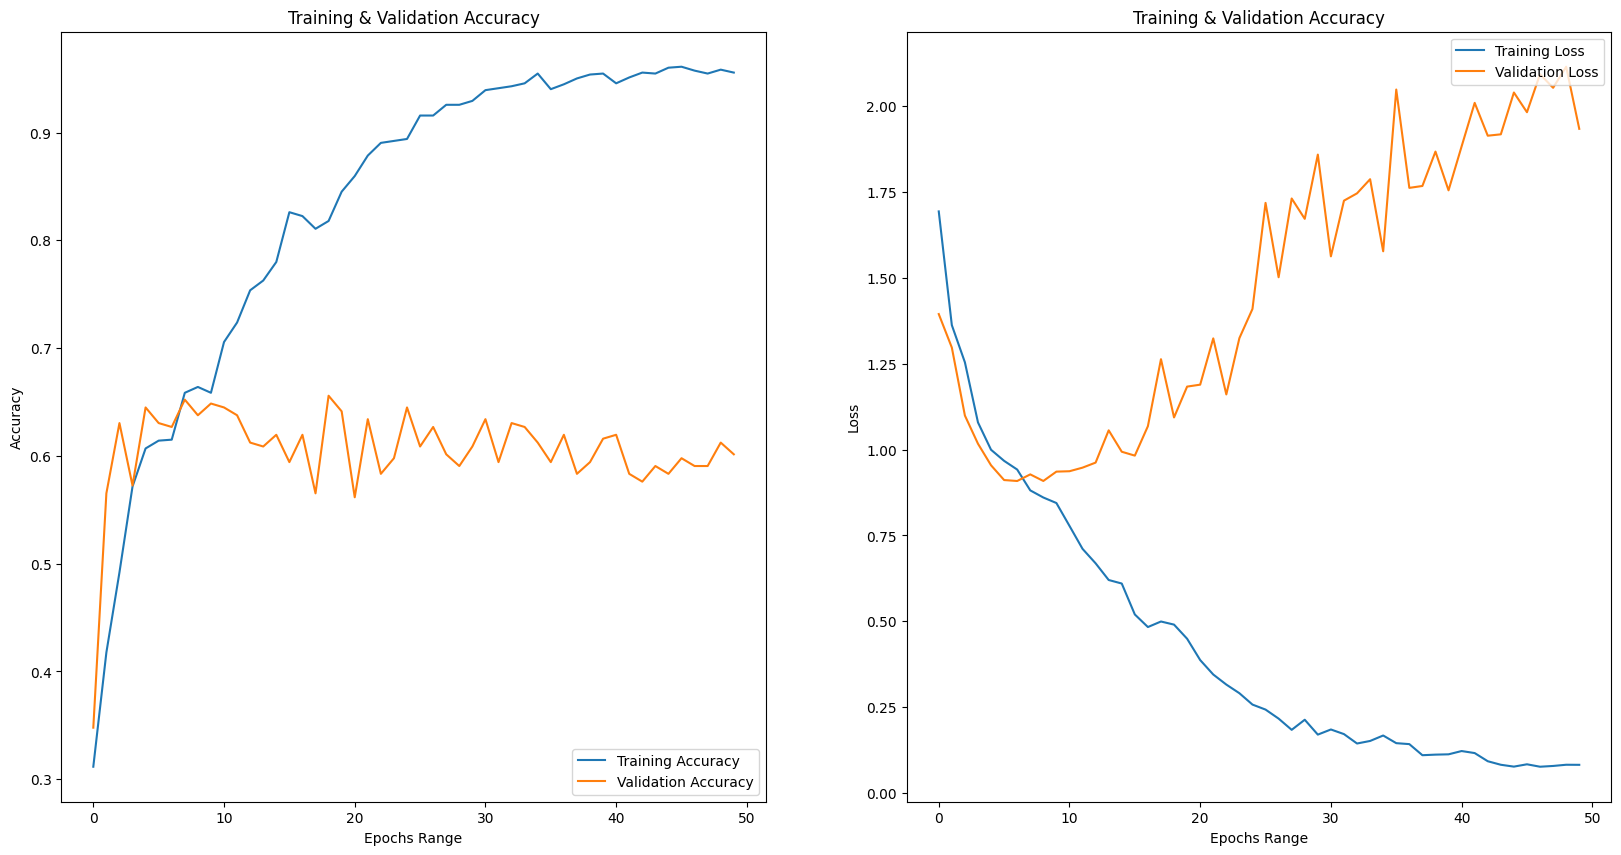

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 50
epochs_range = range(epochs)

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
plt.xlabel('Epochs Range')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs Range')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title('Training & Validation Accuracy')

plt.show()

Though the progress was unstable, the accuracy of train data slowly increased and the losses of train data slowly decreased. However, the same condition did not occur to the validation data. The accuracy and losses of validation data had no significance changes during all epoch process. Therefore, it could be concluded that the model is overfit, because it works well on training set but performs worse on validation set.

#### **2.2. Predicting Testing Set**

In [ ]:
class_names = ["actinic keratosis", "basal cell carcinoma", "dermatofibroma", "melanoma", "nevus"]
image_names = [path.split("/")[-1] for path in np.array(test_ds.file_paths)]

##### **2.2.1. Use Model For Prediction**

In [ ]:
# Make predictions
y_pred = model.predict(test_ds)
y_pred_rounded = np.round(y_pred, decimals=2)

2/2 [==============================] - 12s 54ms/step


In [ ]:
import pandas as pd

# Convert y_pred_rounded to a pandas dataframe
df = pd.DataFrame(y_pred_rounded, columns=class_names)
df['Image Name'] = image_names

max_probs_idx = np.argmax(y_pred_rounded, axis=1)
max_probs_classes = [class_names[i] for i in max_probs_idx]
df['Highest Probability'] = max_probs_classes

##### **2.2.2. Prediction Results**

In [ ]:
df.head(5)

,actinic keratosis,basal cell carcinoma,dermatofibroma,melanoma,nevus,Image Name,Highest Probability
0,0.0,0.00,0.00,0.00,1.0,ISIC_0000056.jpg,nevus
1,0.0,0.00,0.00,0.00,1.0,ISIC_0024452.jpg,nevus
2,0.0,0.95,0.01,0.04,0.0,ISIC_0024472.jpg,basal cell carcinoma
3,0.0,0.00,0.00,0.00,1.0,ISIC_0000007.jpg,nevus
4,0.0,0.00,0.00,0.00,1.0,ISIC_0024994.jpg,nevus


Looking at the model's accuracy, it indicated that the model was overfit due to imbalance classes of the data. As a result, the predictions of new data might be inaccurate. The image with the name `ISIC_0024472` was predicted belonged to *nevus*. However, in reality, that image belongs to *Basal cell carcinoma*.

## **Graph Neural Network**

### **1. Data Preprocessing**

#### **1.1. Divide Image in Train Folder into Train and Validation Set**

In [ ]:
# Define parameters for the loader
batch_size = 64
img_height = 180
img_width = 180

In [ ]:
train_dir = pathlib.Path("/content/drive/MyDrive/skin-cancer-isic/Train")
test_dir = pathlib.Path("/content/drive/MyDrive/skin-cancer-isic/Test")
train_split_dir = '/content/drive/MyDrive/skin-cancer-isic/Train/Train_Split'
val_split_dir = '/content/drive/MyDrive/skin-cancer-isic/Train/Validation_Split'

In [ ]:
if not os.path.exists(train_split_dir):
  os.makedirs(train_split_dir)

if not os.path.exists(val_split_dir):
  os.makedirs(val_split_dir)

*Create two new directories for train and validation data if not existed.* The idea of creating these two new directories is to split the data from the original training directory into a new splitted train data and validation data for training purposes.

In [ ]:
split_ratio = 0.2

for root, dirs, files in os.walk(train_dir):
    if root == train_split_dir or root == val_split_dir or root == '/content/drive/MyDrive/skin-cancer-isic/Train':
        continue

    rel_dir = os.path.relpath(root, train_dir)
    train_subdir = os.path.join(train_split_dir, rel_dir)
    val_subdir = os.path.join(val_split_dir, rel_dir)
    os.makedirs(train_subdir, exist_ok=True)
    os.makedirs(val_subdir, exist_ok=True)

    val_size = int(len(files) * split_ratio)
    val_files = files[:val_size]
    train_files = files[val_size:]

    for file in val_files:
        src_file = os.path.join(root, file)
        dest_file = os.path.join(val_subdir, file)
        shutil.copy(src_file, dest_file)

    for file in train_files:
        src_file = os.path.join(root, file)
        dest_file = os.path.join(train_subdir, file)
        shutil.copy(src_file, dest_file)

shutil.rmtree(os.path.join(train_split_dir, "Train_Split"))
shutil.rmtree(os.path.join(train_split_dir, "Validation_Split"))
shutil.rmtree(os.path.join(val_split_dir, "Train_Split"))
shutil.rmtree(os.path.join(val_split_dir, "Validation_Split"))

Dataset proportion is divided into 80% for training set, and 20% for validation set.

In [ ]:
# shutil.rmtree(train_split_dir)
# shutil.rmtree(val_split_dir)

# os.path.exists(train_split_dir)
# os.path.exists(val_split_dir)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   samplewise_center=True,
                                   samplewise_std_normalization=True)

val_datagen = ImageDataGenerator(rescale=1./255,
                                   samplewise_center=True,
                                   samplewise_std_normalization=True)

test_datagen = ImageDataGenerator(rescale=1./255,
                                  samplewise_center=True,
                                  samplewise_std_normalization=True)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_split_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

train_generator = val_datagen.flow_from_directory(val_split_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

Found 1106 images belonging to 5 classes.
Found 274 images belonging to 5 classes.
Found 80 images belonging to 5 classes.


In [ ]:
def files_count(dir_path):
  count = 0
  for root, dirs, files in os.walk(dir_path):
      for file in files:
          count += 1
  return count

In [ ]:
print("Number of Images in Train Set : ", files_count(train_split_dir))
print("Number of Images in Validation Set  : ", files_count(val_split_dir))
classes = os.listdir(train_split_dir)
print(classes)

Number of Images in Train Set :  1106
Number of Images in Validation Set  :  274
['actinic keratosis', 'dermatofibroma', 'nevus', 'basal cell carcinoma', 'melanoma']


There are 5 classes of skin cancer in our dataset. Around 80% or 1104 files of the original data will be used for training, and 20% or 276 files of the original data will be used for validation.

#### **1.2. Data Visualization**

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_split_dir,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 1106 files belonging to 5 classes.


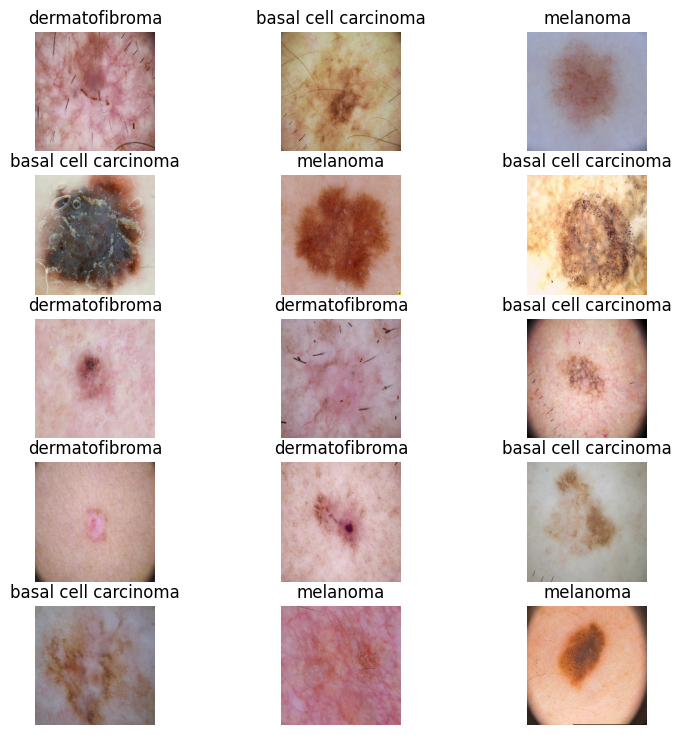

In [ ]:
plt.figure(figsize = (9,9))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

Displayed some images to give overall depiction of skin cancer images in our dataset.

#### **1.3. Data Augmentation**

In [ ]:
# See Data Proportion
path = [x for x in glob(os.path.join(train_split_dir, '*', '*.jpg'))]
lesion = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(train_split_dir, '*', '*.jpg'))]
df_dict = dict(zip(path, lesion))
df = pd.DataFrame(list(df_dict.items()), columns = ['Path', 'Label'])
df[['Label']].value_counts(normalize = False)

Label               
melanoma                351
basal cell carcinoma    301
nevus                   286
actinic keratosis        92
dermatofibroma           76
dtype: int64

In [ ]:
# Define the directory where the augmented images will be saved
augmented_dir = '/content/drive/MyDrive/skin-cancer-isic/Train/Train_Split/Augmented'
os.makedirs(augmented_dir, exist_ok=True)

def myFunc(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    bgr_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return bgr_image

# Define the data generator with the desired augmentation settings
data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function = myFunc
)

target_num_images = max(df[['Label']].value_counts(normalize = False))

In [ ]:
# Loop over each folder in the original directory
for folder in pathlib.Path(train_split_dir).glob("*"):
    new_folder_path = pathlib.Path(augmented_dir) / folder.name
    new_folder_path.mkdir(parents=True, exist_ok=True)

    # Count the number of images in the folder
    num_images = len(list(folder.glob("*")))
    num_images_to_generate = target_num_images - num_images

    count = 0
    for img_path in folder.glob("*.jpg"): # Loop over each image in the folder
      shutil.copy(img_path, new_folder_path) # Copy the original image file to the augmented directory
      img = cv2.imread(str(img_path)) # Load the image
      if img is not None:
        img = img.reshape((1,) + img.shape) # Expand its dimensions to match the input shape in data_generator
        if count < num_images_to_generate:
          if(folder.name == 'actinic keratosis'):
            i = 0
            for batch in data_generator.flow(img, batch_size=1, save_to_dir=str(new_folder_path), save_prefix="aug", save_format="jpg"):
                i += 1
                if count <= 76:
                  if i >= 3:  # generate 3 augmented images
                    break
                else:
                  if i >= 2:  # generate 2 augmented images
                    break
          elif(folder.name == 'dermatofibroma'):
            i = 0
            for batch in data_generator.flow(img, batch_size=1, save_to_dir=str(new_folder_path), save_prefix="aug", save_format="jpg"):
                i += 1
                if count <= 48:
                  if i >= 4:  # generate 4 augmented images
                    break
                else:
                  if i >= 3:  # generate 3 augmented images
                    break
          else:
            for batch in data_generator.flow(img, batch_size=1, save_to_dir=str(new_folder_path), save_prefix="aug", save_format="jpg"):
                break
      count += 1

dir_remove = os.path.join(augmented_dir, "Augmented")
shutil.rmtree(dir_remove)

In [ ]:
path = [x for x in glob(os.path.join(augmented_dir, '*', '*.jpg'))]
lesion = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(augmented_dir, '*', '*.jpg'))]
df_dict = dict(zip(path, lesion))
df = pd.DataFrame(list(df_dict.items()), columns = ['Path', 'Label'])
df[['Label']].value_counts(normalize = False)

Label               
basal cell carcinoma    351
melanoma                351
nevus                   350
dermatofibroma          349
actinic keratosis       348
dtype: int64

In [ ]:
path = [x for x in glob(os.path.join(val_split_dir, '*', '*.jpg'))]
lesion = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(val_split_dir, '*', '*.jpg'))]
df_dict = dict(zip(path, lesion))
df = pd.DataFrame(list(df_dict.items()), columns = ['Path', 'Label'])
df[['Label']].value_counts(normalize = False)

Label               
melanoma                87
basal cell carcinoma    75
nevus                   71
actinic keratosis       22
dermatofibroma          19
dtype: int64

In [ ]:
# Define the directory where the augmented images will be saved
val_augmented_dir = '/content/drive/MyDrive/skin-cancer-isic/Train/Validation_Split/Augmented'
os.makedirs(val_augmented_dir, exist_ok=True)

def myFunc(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    bgr_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return bgr_image

# Define the data generator with the desired augmentation settings
data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function = myFunc
)

target_num_images = max(df[['Label']].value_counts(normalize = False))

In [ ]:
# Loop over each folder in the original directory
for folder in pathlib.Path(val_split_dir).glob("*"):
    new_folder_path = pathlib.Path(val_augmented_dir) / folder.name
    new_folder_path.mkdir(parents=True, exist_ok=True)

    # Count the number of images in the folder
    num_images = len(list(folder.glob("*")))
    num_images_to_generate = target_num_images - num_images

    count = 0
    for img_path in folder.glob("*.jpg"): # Loop over each image in the folder
      shutil.copy(img_path, new_folder_path) # Copy the original image file to the augmented directory
      img = cv2.imread(str(img_path)) # Load the image
      if img is not None:
        img = img.reshape((1,) + img.shape) # Expand its dimensions to match the input shape in data_generator
        if count < num_images_to_generate:
          if(folder.name == 'actinic keratosis'):
            i = 0
            for batch in data_generator.flow(img, batch_size=1, save_to_dir=str(new_folder_path), save_prefix="aug", save_format="jpg"):
                i += 1
                if i >= 3:  # generate 3 augmented images
                  break
          elif(folder.name == 'dermatofibroma'):
            i = 0
            for batch in data_generator.flow(img, batch_size=1, save_to_dir=str(new_folder_path), save_prefix="aug", save_format="jpg"):
                i += 1
                if count <= 10:
                  if i >= 4:  # generate 4 augmented images
                    break
                else:
                  if i >= 3:  # generate 3 augmented images
                    break
          else:
            for batch in data_generator.flow(img, batch_size=1, save_to_dir=str(new_folder_path), save_prefix="aug", save_format="jpg"):
                break
      count += 1

dir_remove = os.path.join(val_augmented_dir, "Augmented")
shutil.rmtree(dir_remove)

In [ ]:
path = [x for x in glob(os.path.join(val_augmented_dir, '*', '*.jpg'))]
lesion = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(val_augmented_dir, '*', '*.jpg'))]
df_dict = dict(zip(path, lesion))
df = pd.DataFrame(list(df_dict.items()), columns = ['Path', 'Label'])
df[['Label']].value_counts(normalize = False)

Label               
actinic keratosis       88
basal cell carcinoma    87
dermatofibroma          87
melanoma                87
nevus                   87
dtype: int64

### **2. Delaunay Triangulation**

#### **2.1. Delaunay Points For Training Set**

In [ ]:
# setting random seed so the outputs do not vary between runs
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
pixels = []
labels = []
tris = []

In [ ]:
# Delaunay Points for Train Set
for subdir in os.listdir(augmented_dir):
  print("----------", subdir, "----------")
  subdir_path = os.path.join(augmented_dir, subdir)
  if os.path.isdir(subdir_path):
    for filename in os.listdir(subdir_path):
      if filename.endswith('.jpg'):
        image_path = os.path.join(subdir_path, filename)
        image = cv2.imread(image_path)
        if os.path.getsize(image_path) <= 0:
            continue
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
        color = cv2.cvtColor(image, cv2.IMREAD_COLOR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mask = segmentation.flood(gray, (0, 0), tolerance=50)
        contours = measure.find_contours(mask, 0.5)

        points = []
        for contour in contours:
          n = len(contour)
          indices = np.linspace(0, n-1, 100, dtype=np.int)
          # Ambil hanya 100 poin pertama dari setiap kontur
          points.append(contour[indices][:100])
        points = np.concatenate(points)

        sampled_indices = np.random.choice(points.shape[0], size=100, replace=False)
        points_sampled = points[sampled_indices, :]
        tri = Delaunay(points_sampled, qhull_options='QJ')
        tris.append(tri)

        # `pixel_values` untuk menyimpan pixel2 dari titik2 delaunay
        points_int = points.astype(int)
        pixel_values = color[points_int[:, 0], points_int[:, 1]]
        # pixels.append(pixel_values)

        # Calculate the mean pixel values inside each Delaunay triangle
        mean_pixels = []
        for triangle in tri.simplices:
            mean_pixel = np.mean(pixel_values[triangle], axis=0)
            mean_pixels.append(mean_pixel)
        mean_pixels = np.array(mean_pixels)
        pixels.append(mean_pixels)

        labels.append(subdir)

---------- actinic keratosis ----------


<ipython-input-71-8bdfddbc7192>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.linspace(0, n-1, 100, dtype=np.int)


---------- dermatofibroma ----------
---------- nevus ----------
---------- basal cell carcinoma ----------
---------- melanoma ----------


In [ ]:
le = LabelEncoder()
labels = le.fit_transform(labels)

Labels from the train set and validation set are needed to be encoded for training the purposes. Arrangements of the encoded labels are shown below:

**Class | Label**
1. actinic keratosis | 0
2. basal cell carcinoma | 1
3. dermatofibroma | 2
4. melanoma | 3
5. nevus | 4

In [ ]:
resized_pixels = []
for pixel in pixels:
    resized_pixel = cv2.resize(pixel, (100, 100))
    resized_pixels.append(resized_pixel)

pixels_array = np.array(resized_pixels, dtype=np.float32)
print("Pixel Shape : ", pixels_array.shape)
labels_array = np.array(labels, dtype=np.float32)
print("Label Shape : ", labels_array.shape)

print(pixels_array.dtype)
print(labels_array.dtype)

Pixel Shape :  (1749, 100, 100)
Label Shape :  (1749,)
float32
float32


*Create Adjacency Matrix From `tris`*

In [ ]:
n_images = len(tris)
n_pixels = tris[0].points.shape[0]  # use .points attribute to get point coordinates

# Create 3D array to store adjacency matrix for each image
tris_adjs = np.zeros((n_images, n_pixels, n_pixels), dtype=int)

# Loop over images to compute pairwise Euclidean distances and create adjacency matrix
for i in range(n_images):
    dists = np.zeros((n_pixels, n_pixels))
    for j in range(n_pixels):
        for k in range(j+1, n_pixels):
            dists[j,k] = np.linalg.norm(tris[i].points[j] - tris[i].points[k])  # use .points attribute
            dists[k,j] = dists[j,k] # Symmetric matrix

    # Create sparse adjacency matrix
    threshold = 0.1
    tris_adjs[i,:,:] = (dists <= threshold).astype(int)

print("Adjacency Matrix Shape : ", tris_adjs.shape)

Adjacency Matrix Shape :  (1749, 100, 100)


#### **2.2. Delaunay Points For Validation Set**

In [ ]:
# setting random seed so the outputs do not vary between runs
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
val_pixels = []
val_labels = []
val_tris = []

In [ ]:
# Delaunay Points for Validation Set
for subdir in os.listdir(val_augmented_dir):
  print("----------", subdir, "----------")
  subdir_path = os.path.join(val_augmented_dir, subdir)
  if os.path.isdir(subdir_path):
    for filename in os.listdir(subdir_path):
      if filename.endswith('.jpg'):
        image_path = os.path.join(subdir_path, filename)
        image = cv2.imread(image_path)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
        color = cv2.cvtColor(image, cv2.IMREAD_COLOR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mask = segmentation.flood(gray, (0, 0), tolerance=50)
        contours = measure.find_contours(mask, 0.5)

        points = []
        for contour in contours:
          n = len(contour)
          indices = np.linspace(0, n-1, 100, dtype=np.int)
          points.append(contour[indices][:100])
        points_val = np.concatenate(points)

        sampled_indices = np.random.choice(points_val.shape[0], size=100, replace=False)
        val_points_sampled = points_val[sampled_indices, :]
        val_tri = Delaunay(val_points_sampled, qhull_options='QJ')
        val_tris.append(val_tri)

        # `pixel_values` untuk menyimpan pixel2 dari titik2 delaunay
        points_int = points_val.astype(int)
        pixel_values = color[points_int[:, 0], points_int[:, 1]]
        # val_pixels.append(pixel_values)

        # Calculate the mean pixel values inside each Delaunay triangle
        mean_pixels = []
        for triangle in val_tri.simplices:
            mean_pixel = np.mean(pixel_values[triangle], axis=0)
            mean_pixels.append(mean_pixel)
        mean_pixels = np.array(mean_pixels)
        val_pixels.append(mean_pixels)

        val_labels.append(subdir)

---------- actinic keratosis ----------


<ipython-input-77-d9fce1017b51>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.linspace(0, n-1, 100, dtype=np.int)


---------- dermatofibroma ----------
---------- nevus ----------
---------- basal cell carcinoma ----------
---------- melanoma ----------


In [ ]:
le = LabelEncoder()
val_labels = le.fit_transform(val_labels)

In [ ]:
resized_pixels = []
for pixel in val_pixels:
    resized_pixel = cv2.resize(pixel, (100, 100))
    resized_pixels.append(resized_pixel)

val_pixels = np.array(resized_pixels, dtype=np.float32)
print("Validation Pixel Shape : ", val_pixels.shape)
val_labels = np.array(val_labels, dtype=np.float32)
print("Validation Label Shape : ", val_labels.shape)

print(val_pixels.dtype)
print(val_labels.dtype)

Validation Pixel Shape :  (412, 100, 100)
Validation Label Shape :  (412,)
float32
float32


In [ ]:
n_images = len(val_tris)
n_pixels = val_tris[0].points.shape[0]  # use .points attribute to get point coordinates

# Create 3D array to store adjacency matrix for each image
val_tris_adjs = np.zeros((n_images, n_pixels, n_pixels), dtype=int)

# Loop over images to compute pairwise Euclidean distances and create adjacency matrix
for i in range(n_images):
    dists = np.zeros((n_pixels, n_pixels))
    for j in range(n_pixels):
        for k in range(j+1, n_pixels):
            dists[j,k] = np.linalg.norm(val_tris[i].points[j] - val_tris[i].points[k])  # use .points attribute
            dists[k,j] = dists[j,k] # Symmetric matrix

    # Create sparse adjacency matrix
    threshold = 0.1
    val_tris_adjs[i,:,:] = (dists <= threshold).astype(int)

print("Adjacency Matrix Shape : ", val_tris_adjs.shape)

Adjacency Matrix Shape :  (412, 100, 100)


### **3. Graph Neural Network (GNN)**

1. Firstly, we define the shape of our inputs. There are 3 inputs:
 - `pixels_inputs` containing pixels of each images. Defined shape: 100 x 100
 - `labels_inputs` containing labels of each image. Defined shape: 5
 - `adjs_inputs` containing the adjacency matrix from each images's delaunay points. Defined shape: 100 x 100
2. Then, we create and define the GCN layers for our model:
 - 4 GCN layers with 16, 32, 64, and 128 filters
 - 4 dropout layers to reduce overfitting
 - 1 flatten layer
 - 1 dense layer for an output layer
3. After that, we compile the model using model.compile to define the loss function, optimizers, and metrics for prediction.
4. Then, we train the model using model.fit.
5. Lastly, we check our model's overall accuracy and loss by plotting the accuracy and loss function.

**After model creation and evaluation, we apply the model to predict the testing set.**

#### **3.1. Define Layers**

In [ ]:
num_classes = len(set(labels))
labels_array = to_categorical(labels_array, num_classes = num_classes)
val_labels = to_categorical(val_labels, num_classes = num_classes)

In [ ]:
# Define model inputs
pixel_inputs = layers.Input(shape=pixels_array.shape[1:])
adjs_inputs = layers.Input(shape=tris_adjs.shape[1:])

In [ ]:
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
# Define GCN layers
gc0 = GCNConv(32, activation='relu', kernel_regulizer='l2')([pixel_inputs, adjs_inputs])
gc0 = layers.BatchNormalization()(gc0)
gc1 = GCNConv(64, activation='relu', kernel_regulizer='l2')([gc0, adjs_inputs])
gc1 = layers.BatchNormalization()(gc1)
gc2 = GCNConv(128, activation='relu', kernel_regulizer='l2')([gc1, adjs_inputs])
gc2 = layers.BatchNormalization()(gc2)
gc3 = GCNConv(256, activation='relu', kernel_regulizer='l2')([gc2, adjs_inputs])
gc3 = layers.BatchNormalization()(gc3)
gc4 = GCNConv(512, activation='relu', kernel_regulizer='l2')([gc3, adjs_inputs])
gc4 = layers.BatchNormalization()(gc4)
flatten_layer = layers.Flatten()(gc4)
output_layer = layers.Dense(units=num_classes, activation="softmax")(flatten_layer)

In [ ]:
output_layer.shape

TensorShape([None, 5])

The expected output from the result above are 5.

#### **3.2. Model Fitting**

In [ ]:
# Define & compile the model
model = tf.keras.models.Model(inputs=[pixel_inputs, adjs_inputs], outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 100)]   0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 100, 100)]   0           []                               
                                                                                                  
 gcn_conv_10 (GCNConv)          (None, 100, 32)      3232        ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 batch_normalization_10 (BatchN  (None, 100, 32)     128         ['gcn_conv_10[0][0]']      

In [ ]:
# Train the model
history = model.fit(
    x=[pixels_array, tris_adjs],
    y=labels_array,
    batch_size=64,
    epochs=45,
    validation_data=([val_pixels, val_tris_adjs], val_labels)
)

Epoch 1/45
28/28 [==============================] - 10s 232ms/step - loss: 3.8048 - accuracy: 0.2790 - val_loss: 90.9245 - val_accuracy: 0.2136
Epoch 2/45
28/28 [==============================] - 6s 200ms/step - loss: 3.1831 - accuracy: 0.3648 - val_loss: 9.5482 - val_accuracy: 0.3252
Epoch 3/45
28/28 [==============================] - 5s 195ms/step - loss: 2.9116 - accuracy: 0.3671 - val_loss: 11.7583 - val_accuracy: 0.2282
Epoch 4/45
28/28 [==============================] - 6s 221ms/step - loss: 2.6215 - accuracy: 0.3962 - val_loss: 4.6301 - val_accuracy: 0.2621
Epoch 5/45
28/28 [==============================] - 6s 227ms/step - loss: 2.0201 - accuracy: 0.4454 - val_loss: 5.0878 - val_accuracy: 0.1893
Epoch 6/45
28/28 [==============================] - 6s 234ms/step - loss: 1.9333 - accuracy: 0.4574 - val_loss: 3.5958 - val_accuracy: 0.1869
Epoch 7/45
28/28 [==============================] - 6s 201ms/step - loss: 1.9171 - accuracy: 0.4889 - val_loss: 3.6358 - val_accuracy: 0.2573
Epo

After setting the number of epoch to 50, the number of loss for train and validation are slowly getting better. Despite the improvement, the accuracy of train and validation has no significant changes at all.

#### **3.3. Evaluating Model's Accuracy & Loss**

In [ ]:
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]

print("Training loss:", train_loss)
print("Training accuracy:", train_accuracy)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

Training loss: 1.3591783046722412
Training accuracy: 0.619210958480835
Validation loss: 25.598421096801758
Validation accuracy: 0.2160194218158722


In [ ]:
val_loss, val_accuracy = model.evaluate([val_pixels, val_tris_adjs], val_labels)
train_loss, train_accuracy = model.evaluate([pixels_array, tris_adjs], labels_array)

print("Training loss:", train_loss)
print("Training accuracy:", train_accuracy)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

55/55 [==============================] - 2s 33ms/step - loss: 19.4128 - accuracy: 0.4191
Training loss: 19.412839889526367
Training accuracy: 0.41909661889076233
Validation loss: 25.598424911499023
Validation accuracy: 0.2160194218158722


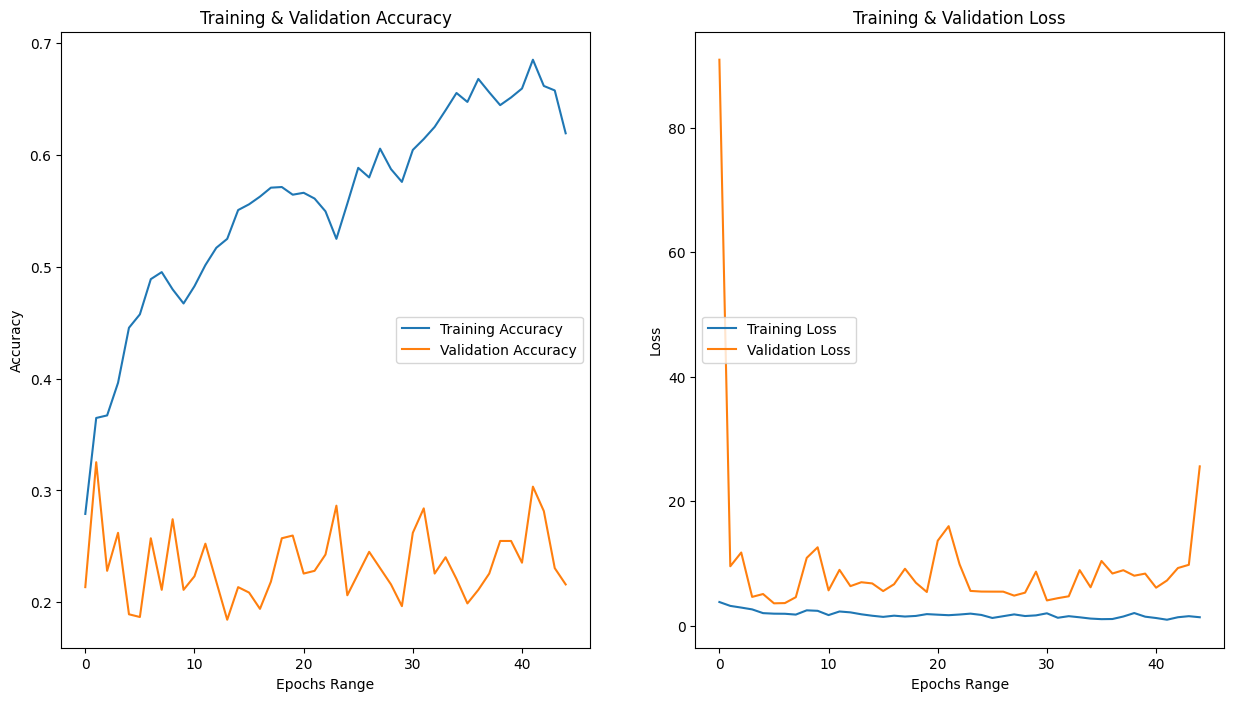

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(45)

plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
plt.xlabel('Epochs Range')
plt.ylabel('Accuracy')
plt.legend(loc = 'center right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs Range')
plt.ylabel('Loss')
plt.legend(loc = 'center left')
plt.title('Training & Validation Loss')

plt.show()

From the visualization above, the accuracy of training and validation are close to each other. Unlike the previous modeling using CNN, this method lowers the chance of overfitting. However, compared to the results of using CNN, the loss during the training process of this method are much more significant.

#### **3.4. Predicting Testing Set**

In [ ]:
test_split_dir = '/content/drive/MyDrive/skin-cancer-isic/Test'

In [ ]:
# setting random seed so the outputs do not vary between runs
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

##### **3.4.1. Delaunay Points For Testing Set**

In [ ]:
test_pixels = []
test_tris = []
test_labels = []
image_names = []

In [ ]:
# Delaunay Points for Testing Set
for subdir in os.listdir(test_split_dir):
  print("----------", subdir, "----------")
  subdir_path = os.path.join(test_split_dir, subdir)
  if os.path.isdir(subdir_path):
    for filename in os.listdir(subdir_path):
      if filename.endswith('.jpg'):
        image_path = os.path.join(subdir_path, filename)
        image_name = filename.split('.')[0]
        image_names.append(image_name)

        image = cv2.imread(image_path)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
        color = cv2.cvtColor(image, cv2.IMREAD_COLOR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mask = segmentation.flood(gray, (0, 0), tolerance=50)
        contours = measure.find_contours(mask, 0.5)

        points = []
        for contour in contours:
          n = len(contour)
          indices = np.linspace(0, n-1, 100, dtype=np.int)
          points.append(contour[indices][:100])
        points_val = np.concatenate(points)

        sampled_indices = np.random.choice(points_val.shape[0], size=100, replace=False)
        val_points_sampled = points_val[sampled_indices, :]
        val_tri = Delaunay(val_points_sampled, qhull_options='QJ')
        test_tris.append(val_tri)

        # `pixel_values` untuk menyimpan pixel2 dari titik2 delaunay
        points_int = points_val.astype(int)
        pixel_values = color[points_int[:, 0], points_int[:, 1]]

        # Calculate the mean pixel values inside each Delaunay triangle
        mean_pixels = []
        for triangle in val_tri.simplices:
            mean_pixel = np.mean(pixel_values[triangle], axis=0)
            mean_pixels.append(mean_pixel)
        mean_pixels = np.array(mean_pixels)
        test_pixels.append(mean_pixels)

        test_labels.append(subdir)

---------- melanoma ----------


<ipython-input-137-2f9f02e1b306>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.linspace(0, n-1, 100, dtype=np.int)


---------- dermatofibroma ----------
---------- actinic keratosis ----------
---------- nevus ----------
---------- basal cell carcinoma ----------


In [ ]:
resized_pixels = []
for pixel in test_pixels:
    resized_pixel = cv2.resize(pixel, (100, 100))
    resized_pixels.append(resized_pixel)

test_pixels = np.array(resized_pixels, dtype=np.float32)
print("Testing Pixel Shape : ", test_pixels.shape)

print(test_pixels.dtype)

Testing Pixel Shape :  (80, 100, 100)
float32


*Create Adjacency Matrix From `test_tris`*

In [ ]:
n_images = len(test_tris)
n_pixels = test_tris[0].points.shape[0]  # use .points attribute to get point coordinates

# Create 3D array to store adjacency matrix for each image
test_tris_adjs = np.zeros((n_images, n_pixels, n_pixels), dtype=int)

# Loop over images to compute pairwise Euclidean distances and create adjacency matrix
for i in range(n_images):
    dists = np.zeros((n_pixels, n_pixels))
    for j in range(n_pixels):
        for k in range(j+1, n_pixels):
            dists[j,k] = np.linalg.norm(test_tris[i].points[j] - test_tris[i].points[k])  # use .points attribute
            dists[k,j] = dists[j,k] # Symmetric matrix

    # Create sparse adjacency matrix
    threshold = 2.5
    test_tris_adjs[i,:,:] = (dists <= threshold).astype(int)

print("Adjacency Matrix Shape : ", test_tris_adjs.shape)

Adjacency Matrix Shape :  (80, 100, 100)


##### **3.4.2. Use Model For Prediction**

In [ ]:
# Make predictions
y_pred = model.predict([test_pixels, test_tris_adjs])
y_pred_rounded = np.round(y_pred, decimals=2)

3/3 [==============================] - 0s 30ms/step


In [ ]:
import pandas as pd

class_names = ["actinic keratosis", "basal cell carcinoma", "dermatofibroma", "melanoma", "nevus"]

# Convert y_pred_rounded to a pandas dataframe
df = pd.DataFrame(y_pred_rounded, columns=class_names)
df['Image Name'] = image_names

max_probs_idx = np.argmax(y_pred_rounded, axis=1)
max_probs_classes = [class_names[i] for i in max_probs_idx]
df['Highest Probability'] = max_probs_classes
df['Actual Class'] = test_labels

##### **3.4.3. Prediction Results**

In [ ]:
df.iloc[72:77]

,actinic keratosis,basal cell carcinoma,dermatofibroma,melanoma,nevus,Image Name,Highest Probability,Actual Class
72,0.27,0.05,0.41,0.10,0.17,ISIC_0024411,dermatofibroma,basal cell carcinoma
73,0.21,0.58,0.18,0.00,0.03,ISIC_0024472,basal cell carcinoma,basal cell carcinoma
74,0.00,0.02,0.01,0.00,0.97,ISIC_0024403,nevus,basal cell carcinoma
75,0.32,0.26,0.03,0.10,0.29,ISIC_0024454,actinic keratosis,basal cell carcinoma
76,0.02,0.00,0.37,0.01,0.60,ISIC_0024431,nevus,basal cell carcinoma


The last accuracy result for the training process are 34%, this resulted in the result of the training process. Let's take a look at the prediction result above. Image with the name `ISIC_0000022` was predicted to be in *Dermatofibroma*. In reality, that image belongs to *Melanoma*. Then, image with the name `ISIC_0000030` was predicted to be in *Nevus* when in reality that image belongs to *Melanoma*.

## **Conclusion**

Convolutional Neural Network (CNN) produced higher accuracy rather than modeling using Graph Neural Network (GNN). Despite the higher accuracy, the modeling produced by CNN overfitted due to unbalanced data throughout the classes. While GNN, works fine with unbalanced data as the model was trained using the results from the Delaunay Triangulation method. However, the points produced by the Delaunay method some are inaccurate. In the images provided by the dataset, some of the pictures have thick hair which interfere the process of the Delaunay method to find the coordinates of the skin cancer surroundings. As a result, some coordinates stored might be the coordinates that surround the body hair not the skin cancer itself.

In [ ]:
shutil.rmtree('/content/drive/MyDrive/skin-cancer-isic/Train/Train_Split')
shutil.rmtree('/content/drive/MyDrive/skin-cancer-isic/Train/Validation_Split')